In [1]:
from imp import reload
from utils import utils
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import re
reload(utils)
from matplotlib import pyplot as plt

In [2]:
# 统计训练集 txt 的数量
# 统计测试集 txt 的数量
print('train txt file:{}'.format(len(glob('../data/train_data/*.txt'))))
print('test txt file:{}'.format(len(glob('../data/test_data/*.txt'))))

train txt file:2515
test txt file:3956


In [3]:
# 对标签进行分析
label_lst = glob('../data/train_label/*.csv')

label_total = []
for i in tqdm(label_lst):
    label_total.append(pd.read_csv(i).values)

label_total = np.concatenate(label_total, axis=0)
label_total = pd.DataFrame(
    label_total, columns=['ID', 'Category', 'Pos_b', 'Pos_e', 'Privacy'])

100%|████████████████████████████| 2515/2515 [00:06<00:00, 398.76it/s]


### 查看标签种类

In [4]:
print(np.unique(label_total.Category))

['QQ' 'address' 'book' 'company' 'email' 'game' 'government' 'mobile'
 'movie' 'name' 'organization' 'position' 'scene' 'vx']


### 查看标签分布

In [5]:
pd.value_counts(label_total.Category)

position        3580
name            3422
organization    2329
company         2150
address         2056
movie           1901
game            1571
government      1187
scene            990
book             734
mobile           277
email            259
QQ                28
vx                19
Name: Category, dtype: int64

结论：部分标签较少，
mobile，
email，
QQ，vx这几类可以想办法使用规则方式进行匹配

### 查看是否每个 train data 的 txt 都是没换行符号

In [6]:
tdata_lst = glob('../data/train_data/*.txt')

In [7]:
for td in tdata_lst:
    if len(utils.read_txt(td))!=1:
        print(td)

- `../data/train_data/2162.txt`
- `../data/train_data/1907.txt`
- `../data/train_data/488.txt`
- `../data/train_data/2048.txt`
- `../data/train_data/747.txt`
- `../data/train_data/1571.txt`
- `../data/train_data/1501.txt`

结论：以上txt中存在换行符，处理时可以将其删除

### 查看每个 train data 的 txt 中的长度

(array([4.570e+02, 1.025e+03, 3.900e+02, 1.970e+02, 1.410e+02, 8.700e+01,
        7.400e+01, 4.200e+01, 2.800e+01, 2.300e+01, 2.100e+01, 9.000e+00,
        9.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00]),
 array([  6. ,  54.4, 102.8, 151.2, 199.6, 248. , 296.4, 344.8, 393.2,
        441.6, 490. , 538.4, 586.8, 635.2, 683.6, 732. , 780.4, 828.8,
        877.2, 925.6, 974. ]),
 <a list of 20 Patch objects>)

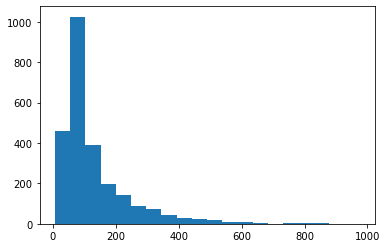

In [8]:
len_lst = []
for td in tdata_lst:
    len_lst.append(len(utils.read_txt(td)[0]))
plt.hist(len_lst,bins=20)

结论：较长的文本，可以后处理为较短的文本，注意不要将 标记 分开了

### test data中的长度分析

../data/test_data\1290.txt
../data/test_data\2652.txt
../data/test_data\2673.txt
../data/test_data\3932.txt
../data/test_data\44.txt


(array([4.170e+02, 2.807e+03, 3.330e+02, 1.560e+02, 9.000e+01, 5.500e+01,
        3.900e+01, 1.800e+01, 1.300e+01, 1.100e+01, 3.000e+00, 5.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00]),
 array([   5.  ,   59.25,  113.5 ,  167.75,  222.  ,  276.25,  330.5 ,
         384.75,  439.  ,  493.25,  547.5 ,  601.75,  656.  ,  710.25,
         764.5 ,  818.75,  873.  ,  927.25,  981.5 , 1035.75, 1090.  ]),
 <a list of 20 Patch objects>)

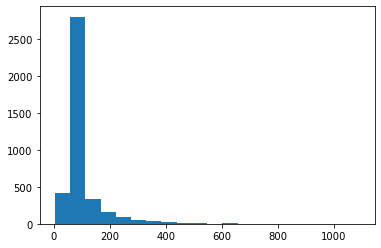

In [9]:
# 查看是否每个 test data 的 txt 都是没换行符号
tedata_lst = glob('../data/test_data/*.txt')
for td in tedata_lst:
    if len(utils.read_txt(td)) != 1:
        print(td)

        
# 查看每个 test data 的 txt 中的长度
len_te_lst = []
for td in tedata_lst:
    len_te_lst.append(len(utils.read_txt(td)[0]))
plt.hist(len_te_lst, bins=20)

结论：若预测标签中存在换行符，注意在预测结果中删除换行符

### movie标签中存在的起止标点符号问题

In [13]:
label_total[label_total.Category == 'movie'].head(5)

,ID,Category,Pos_b,Pos_e,Privacy
2,0,movie,87,91,《上海滩》
65,1004,movie,74,78,《坏习惯》
83,1006,movie,181,186,《蜘蛛侠2》
111,1011,movie,66,75,（Wheelman）
112,1011,movie,59,65,《汽车驾驶员》


In [14]:
tmp1 = label_total[label_total.Category == 'movie']


def func(x):
    "查找前后标点符号不匹配的标记"
    if x[0] in ('《', '≪', '（', '(', '＜', '“', '「',
                '【') and x[-1] in ('》', '≫', '）', ')', '＞', '”', '」', '】'):
        return True
    else:
        return False


tmp1[~tmp1.Privacy.apply(lambda x: func(x))]

,ID,Category,Pos_b,Pos_e,Privacy
184,1020,movie,71,78,waitress
284,1030,movie,36,46,我人生中最精彩的瞬间》
289,1030,movie,200,203,爱情公寓
369,104,movie,28,29,赤壁
370,104,movie,32,35,建国大业
...,...,...,...,...,...
20118,962,movie,72,81,ToothFairy
20363,988,movie,197,201,欲望都市》
20423,994,movie,6,7,花坞
20424,994,movie,10,12,青花运


### game标签中存在的起止标点符号问题

In [15]:
label_total[label_total.Category == 'game'].head(5)

,ID,Category,Pos_b,Pos_e,Privacy
12,10,game,3,15,《大航海时代online》
15,10,game,93,98,《魔兽世界》
31,1000,game,163,168,《明日之后》
43,1000,game,422,428,《星际争霸2》
44,1000,game,486,487,魔兽


In [16]:
tmp2 = label_total[label_total.Category == 'game']
tmp2[~tmp2.Privacy.apply(lambda x: func(x))]

,ID,Category,Pos_b,Pos_e,Privacy
44,1000,game,486,487,魔兽
59,1002,game,137,140,war3
62,1003,game,15,18,文明IV
63,1003,game,51,55,魔兽争霸3
92,1009,game,5,8,魔兽世界
...,...,...,...,...,...
20361,988,game,136,140,DOTA2
20368,989,game,46,58,环图林格勒女子公路自行车赛
20369,989,game,65,74,世界B级自行车锦标赛
20458,997,game,104,106,魔兽3


### book标签中存在的起止标点符号问题

In [17]:
label_total[label_total.Category == 'book'].head(5)

,ID,Category,Pos_b,Pos_e,Privacy
16,10,book,125,131,沧浪亭名贤祠图
82,1006,book,114,127,《经济适用住房价格管理办法》
85,1007,book,0,3,理财周报
142,1015,book,110,129,《关于禁止播出电脑网络游戏类节目的通知》
157,1018,book,64,69,《开啦街拍》


In [18]:
tmp3 = label_total[label_total.Category == 'book']
tmp3[~tmp3.Privacy.apply(lambda x:func(x))]

,ID,Category,Pos_b,Pos_e,Privacy
16,10,book,125,131,沧浪亭名贤祠图
85,1007,book,0,3,理财周报
246,1024,book,132,135,信息时报
566,1060,book,0,5,爹打老蒋去》
603,1065,book,2,5,大众电影
...,...,...,...,...,...
20178,967,book,109,110,早报
20254,976,book,77,80,绿野仙踪
20255,976,book,88,91,绿野仙踪
20433,996,book,65,68,浮华逝梦


### 查看 train data 中的标点符号

In [19]:
import re

filter_p = re.compile(r'[^\u4e00-\u9fa50-9A-Za-z]')
symbol_lst = []

for td in tdata_lst:
    symbol_lst += re.findall(filter_p, utils.read_txt(td)[0])

symbol_lst = np.unique(symbol_lst)

In [20]:
symbol_lst

array(['\t', '!', '"', '#', '%', '&', "'", '(', ')', '*', '+', '-', '.',
       '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_',
       '`', '{', '|', '}', '~', '«', '·', '»', '×', 'ω', 'ค', 'ช', 'ต',
       'ะ', 'า', 'โ', '\u2006', '—', '‘', '’', '“', '”', '•', '…',
       '\u2029', '\u202a', '\u202c', '※', 'Ⅱ', 'Ⅲ', 'Ⅳ', 'Ⅶ', 'ⅰ', 'ⅱ',
       'ⅲ', 'ⅳ', 'ⅵ', '↑', '→', '↓', '∩', '∶', '≪', '≫', '⊙', '⋯', '①',
       '②', '─', '┃', '■', '□', '◆', '●', '★', '☆', '☏', '♪', '\u3000',
       '、', '。', '〃', '〈', '〉', '《', '》', '「', '」', '『', '』', '【', '】',
       '〜', 'あ', 'い', 'え', 'が', 'き', 'く', 'こ', 'し', 'す', 'た', 'ち', 'っ',
       'つ', 'て', 'で', 'と', 'な', 'に', 'の', 'は', 'ま', 'み', 'や', 'ら', 'る',
       'れ', 'を', 'ん', 'コ', 'ス', 'タ', 'ト', 'ニ', '・', 'ー', '䢖', '녕', '세',
       '안', '요', '하', '\ue056', '\ue253', '\ue316', '\ue404', '\ue41d',
       '\ue449', '\uf87d', '﹐', '﹔', '﹕', '﹗', '﹣', '！', '＂', '＄', '＆',
       '（', '）', '＋', '，', '－', '．', '／', '０', '６', '：', '；', '＜', 

In [21]:
for s in ('.', '。', '!', '！', '?', '？', '⋯', '…', '﹗'):
    if s not in symbol_lst:
        print(s)

### 查看标签中是否有标点符号

In [22]:
import re

filter_p = re.compile(r'[^\u4e00-\u9fa50-9A-Za-z]')

symbol_lst = []
for label in label_total.Privacy:
    symbol_lst += re.findall(filter_p, str(label))

symbol_lst = np.unique(symbol_lst)

In [23]:
for s in ('.','。','!','！','?','？','⋯','…','﹗'):
    if s not in symbol_lst:
        print(s)

？
⋯
…
﹗


结论：标签之中有标点符号，直接分句影响识别结果；以上四种标点可以进行分句，不在标签中包含